In [2]:
import folium
from tqdm import tqdm
import math
from scripts import *
from utils import *

import os
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt
import cv2
import ee

In [6]:
grid = 1
box_dim = 5 # km
min_lat, min_lon  = 33.23119, 75.18916
start_date = "2024-05-01"
end_date = "2024-05-06"
project_name = 'Pernote'

os.makedirs(project_name, exist_ok=True)
with open(f'{project_name}/log.txt', 'w') as f:
    f.write(f'Project Name: {project_name}\n')
    f.write(f'Grid size: {grid} x {grid}\n')
    f.write(f'Box Dimension: {box_dim} km\n')
    f.write(f'Bounding Box: {min_lat}, {min_lon}\n')
    f.write(f'Start Date: {start_date}\n')
    f.write(f'End Date: {end_date}\n')

In [11]:
grid = 1
box_dim = 2.5 # km
min_lat, min_lon  = 33.13590, 75.43393
start_date = "2017-02-12"
end_date = "2017-03-04"
project_name = 'Paryote Village'

os.makedirs(project_name, exist_ok=True)
with open(f'{project_name}/log.txt', 'w') as f:
    f.write(f'Project Name: {project_name}\n')
    f.write(f'Grid size: {grid} x {grid}\n')
    f.write(f'Box Dimension: {box_dim} km\n')
    f.write(f'Bounding Box: {min_lat}, {min_lon}\n')
    f.write(f'Start Date: {start_date}\n')
    f.write(f'End Date: {end_date}\n')

In [7]:
# grid = 1
# box_dim = 5 # km
# min_lat, min_lon  = 12.984220, 80.153125
# start_date = "2024-04-19"
# end_date = "2024-05-24"
# project_name = 'Chennai Airport'
# os.makedirs(project_name, exist_ok=True)

# os.makedirs(project_name, exist_ok=True)
# with open(f'{project_name}/log.txt', 'w') as f:
#     f.write(f'Project Name: {project_name}\n')
#     f.write(f'Grid size: {grid} x {grid}\n')
#     f.write(f'Box Dimension: {box_dim} km\n')
#     f.write(f'Bounding Box: {min_lat}, {min_lon}\n')
#     f.write(f'Start Date: {start_date}\n')
#     f.write(f'End Date: {end_date}\n')

In [12]:
g = generate_grid(min_lat, min_lon, distance=box_dim*1000, grid_side=grid)

m = folium.Map(
    location=(min_lat, min_lon),
    zoom_start=15,
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri'
)
for i in range(len(g)):
    folium.Rectangle([(g[i][:2]), (g[i][2:])], color='red', fill='pink',fill_opcity=0.5).add_to(m)

m

In [13]:
NDVI_Before = get_images(km=box_dim, grid=g, grid_dim=grid, script=evalscript_NDVI, 
           date_start=start_date, date_end=start_date, res=1000, 
           box_dim=box_dim, file_name=f"{project_name}/{project_name}-NDVI-Before")

NDVI_After = get_images(km=box_dim, grid=g, grid_dim=grid, script=evalscript_NDVI, 
           date_start=end_date, date_end=end_date, res=1000, 
           box_dim=box_dim, file_name=f"{project_name}/{project_name}-NDVI-After")

True_Color_After = get_images(km=box_dim, grid=g, grid_dim=grid, script=evalscript_True_Color, 
           date_start=end_date, date_end=end_date, res=1000, 
           box_dim=box_dim, file_name=f"{project_name}/{project_name}-True_Color-After")

LSM_Only_After = get_images(km=box_dim, grid=g, grid_dim=grid, script=evalscript_lsm_only, 
           date_start=end_date, date_end=end_date, res=1000, 
           box_dim=box_dim, file_name=f"{project_name}/{project_name}-LSM_Only-After")


0 0 [33.1359, 75.43393, 33.15838304014797, 75.46077938422255] -> 0 1000 0 1000
Saved: Paryote Village/Paryote Village-NDVI-Before.png
----
0 0 [33.1359, 75.43393, 33.15838304014797, 75.46077938422255] -> 0 1000 0 1000
Saved: Paryote Village/Paryote Village-NDVI-After.png
----
0 0 [33.1359, 75.43393, 33.15838304014797, 75.46077938422255] -> 0 1000 0 1000
Saved: Paryote Village/Paryote Village-True_Color-After.png
----
0 0 [33.1359, 75.43393, 33.15838304014797, 75.46077938422255] -> 0 1000 0 1000
Saved: Paryote Village/Paryote Village-LSM_Only-After.png
----


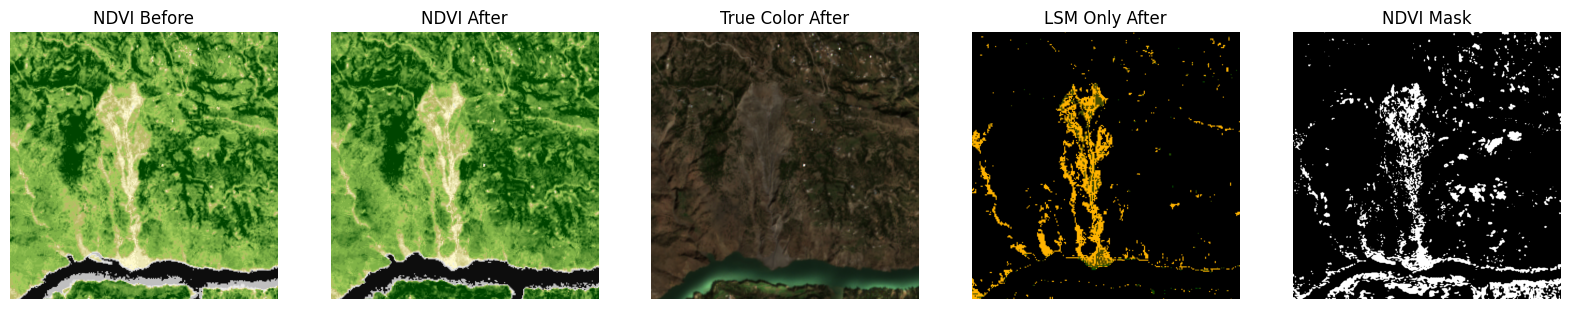

In [14]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 5, 1)
plt.title("NDVI Before")
plt.imshow(NDVI_Before); plt.axis("off")

plt.subplot(1, 5, 2)
plt.title("NDVI After")
plt.imshow(NDVI_After); plt.axis("off")

plt.subplot(1, 5, 3)
plt.title("True Color After")
plt.imshow(True_Color_After); plt.axis("off")

plt.subplot(1, 5, 4)
plt.title("LSM Only After")
plt.imshow(LSM_Only_After); plt.axis("off")

diff = NDVI_Before - NDVI_After
threshold = 0
tolerance = 60
mask = ((NDVI_Before > NDVI_After + tolerance) & (diff > threshold)).astype(np.uint8) * 255
mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
mask_resized = cv2.resize(mask, (mask.shape[0]//4, mask.shape[0]//4))
mask = cv2.resize(mask_resized, mask.shape)
mask = cv2.threshold(mask, 0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]


plt.subplot(1, 5, 5)
plt.title("NDVI Mask")
plt.imshow(mask, cmap='gray'); plt.axis("off")

plt.show()

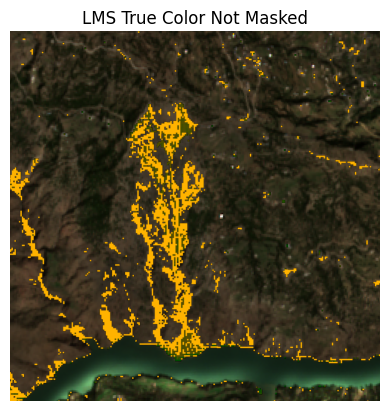

In [15]:
no_mask = np.ones_like(True_Color_After) * 255
LMS_True_Color_dNDVI_not_Masked = True_Color_After.copy()
mask_condition = no_mask == 255
LMS_True_Color_dNDVI_not_Masked[mask_condition] = LSM_Only_After[mask_condition]
black_pixels = np.all(LMS_True_Color_dNDVI_not_Masked == [0, 0, 0], axis=-1)
LMS_True_Color_dNDVI_not_Masked[black_pixels] = True_Color_After[black_pixels]

plt.imshow(LMS_True_Color_dNDVI_not_Masked); plt.axis("off")
plt.title("LMS True Color Not Masked")
plt.imsave(f"{project_name}/{project_name}-LMS_True_Color_dNDVI_Not_Masked.png", LMS_True_Color_dNDVI_not_Masked)

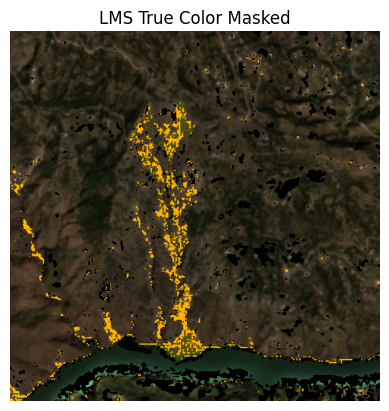

In [17]:
LMS_True_Color_dNDVI_Masked = True_Color_After.copy()
LMS_True_Color_dNDVI_Masked[mask[:,:, None].repeat(3, -1) == 255] = LSM_Only_After[mask[:,:, None].repeat(3, -1) == 255]

plt.imshow(LMS_True_Color_dNDVI_Masked); plt.axis("off")
plt.title("LMS True Color Masked")
plt.imsave(f"{project_name}/{project_name}-LMS_True_Color_dNDVI_Masked.png", LMS_True_Color_dNDVI_Masked)

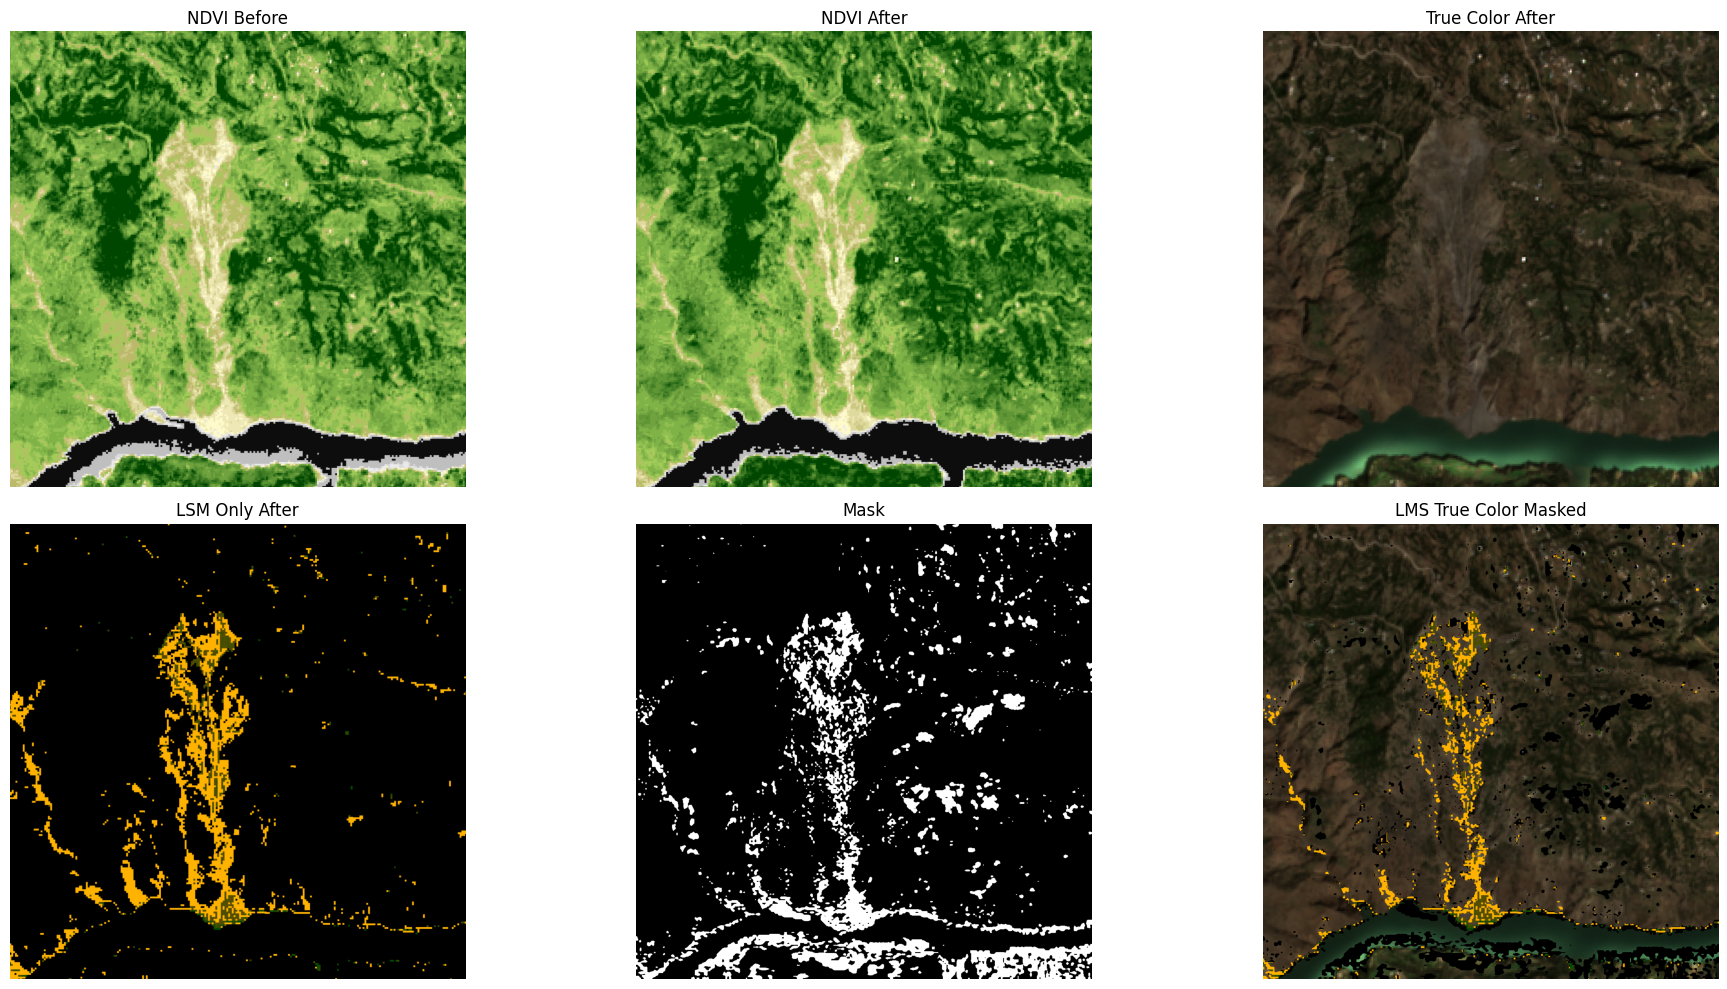

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# First row
axes[0, 0].imshow(NDVI_Before)
axes[0, 0].set_title("NDVI Before")
axes[0, 0].axis("off")

axes[0, 1].imshow(NDVI_After)
axes[0, 1].set_title("NDVI After")
axes[0, 1].axis("off")

axes[0, 2].imshow(True_Color_After)
axes[0, 2].set_title("True Color After")
axes[0, 2].axis("off")

# Second row
axes[1, 0].imshow(LSM_Only_After)
axes[1, 0].set_title("LSM Only After")
axes[1, 0].axis("off")

# Add the mask visualization in grayscale
axes[1, 1].imshow(mask, cmap="gray")
axes[1, 1].set_title("Mask")
axes[1, 1].axis("off")

# Compute masked image
axes[1, 2].imshow(LMS_True_Color_dNDVI_Masked, cmap="gray")
axes[1, 2].set_title("LMS True Color Masked")
axes[1, 2].axis("off")

plt.tight_layout()
plt.savefig(f"{project_name}/{project_name}-combined_image.png")
plt.show()